In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("MaladiesCardiaque") \
    .getOrCreate()

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving heart.csv to heart.csv


In [ ]:
data = spark.read.csv("/content/heart.csv", header=True, inferSchema=True, sep=";")

In [ ]:
data.printSchema()

root
 |-- age,sex,chest_pain_type,resting_bp,cholestoral,fasting_blood_sugar,restecg,max_hr,exang,oldpeak,slope,num_major_vessels,thal,target: string (nullable = true)



In [ ]:
data.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------+
|age,sex,chest_pain_type,resting_bp,cholestoral,fasting_blood_sugar,restecg,max_hr,exang,oldpeak,slope,num_major_vessels,thal,target|
+-----------------------------------------------------------------------------------------------------------------------------------+
|63,1,3,145,233,1,0,150,0,2.3,0,0,1,1                                                                                               |
|37,1,2,130,250,0,1,187,0,3.5,0,0,2,1                                                                                               |
|41,0,1,130,204,0,0,172,0,1.4,2,0,2,1                                                                                               |
|56,1,1,120,236,0,1,178,0,0.8,2,0,2,1                                                                                               |
|57,0,0,120,354,0,1,163,1,0.6,2,0,2,1                         

In [ ]:
# Recharger le fichier CSV en utilisant le séparateur correct
data = spark.read.csv("/content/heart.csv", header=True, inferSchema=True)

# Vérifier les colonnes après rechargement
data.printSchema()
data.show(10, truncate=False)

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- chest_pain_type: integer (nullable = true)
 |-- resting_bp: integer (nullable = true)
 |-- cholestoral: integer (nullable = true)
 |-- fasting_blood_sugar: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- max_hr: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- num_major_vessels: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)

+---+---+---------------+----------+-----------+-------------------+-------+------+-----+-------+-----+-----------------+----+------+
|age|sex|chest_pain_type|resting_bp|cholestoral|fasting_blood_sugar|restecg|max_hr|exang|oldpeak|slope|num_major_vessels|thal|target|
+---+---+---------------+----------+-----------+-------------------+-------+------+-----+-------+-----+-----------------+----+------+
|63 |1  |3   

Phase d'analyse

  ## **Distribution des ages par raport aux maladies**




+---+---+---------------+----------+-----------+-------------------+-------+------+-----+-------+-----+-----------------+----+------+
|age|sex|chest_pain_type|resting_bp|cholestoral|fasting_blood_sugar|restecg|max_hr|exang|oldpeak|slope|num_major_vessels|thal|target|
+---+---+---------------+----------+-----------+-------------------+-------+------+-----+-------+-----+-----------------+----+------+
|  0|  0|              0|         0|          0|                  0|      0|     0|    0|      0|    0|                0|   0|     0|
+---+---+---------------+----------+-----------+-------------------+-------+------+-----+-------+-----+-----------------+----+------+

+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|                sex|   

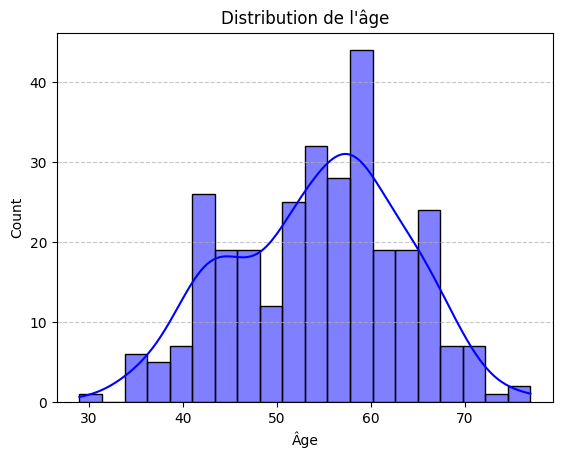

In [ ]:
from pyspark.sql.functions import col, count, when
# Vérification des valeurs manquantes
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()
# Statistiques descriptives
data.describe().show()
# Conversion du DataFrame Spark en Pandas
data_pd = data.toPandas()

# Visualisation : Histogramme de l'âge
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data_pd['age'], kde=True, bins=20, color="blue")
plt.title("Distribution de l'âge")
plt.xlabel("Âge")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# **Regrouppement d'ages selon le target**

---



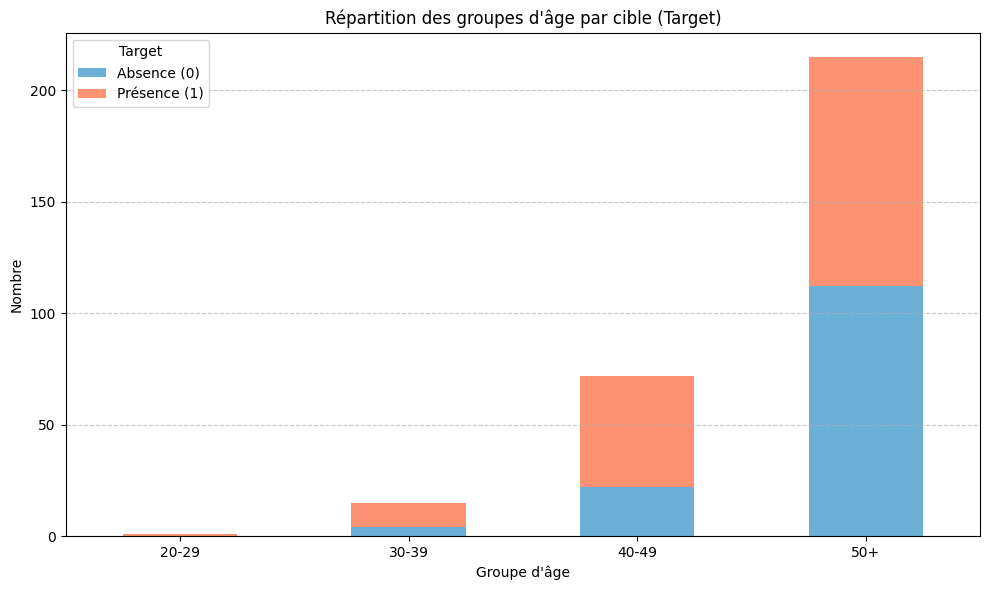

In [ ]:
# Définir les groupes d'âge avec PySpark
data = data.withColumn("age_group",
                       when((col("age") >= 20) & (col("age") < 30), "20-29")
                       .when((col("age") >= 30) & (col("age") < 40), "30-39")
                       .when((col("age") >= 40) & (col("age") < 50), "40-49")
                       .otherwise("50+"))

# Grouper les données par groupes d'âge et cible
grouped_data = data.groupBy("age_group", "target").count().orderBy("age_group")

# Convertir en Pandas pour la visualisation
pandas_df = grouped_data.toPandas()

# Réorganiser les données pour créer un tableau pivoté
pivot_data = pandas_df.pivot(index="age_group", columns="target", values="count").fillna(0)

# Réordonner les groupes d'âge pour qu'ils apparaissent correctement
pivot_data = pivot_data.reindex(["20-29", "30-39", "40-49", "50+"], fill_value=0)

# Tracer un graphique à barres empilées
fig, ax = plt.subplots(figsize=(10, 6))

# Créer des barres empilées pour chaque groupe d'âge
pivot_data.plot(kind="bar", stacked=True, ax=ax, color=["#6baed6", "#fc9272"])

# Ajouter des détails au graphique
plt.title("Répartition des groupes d'âge par cible (Target)")
plt.xlabel("Groupe d'âge")
plt.ylabel("Nombre")
plt.legend(title="Target", labels=["Absence (0)", "Présence (1)"])
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Afficher le graphique
plt.tight_layout()
plt.show()




Repartition des maladies cardiaques par sexe

Répartition des maladies cardiaques par sexe :
sex
Hommes    93
Femmes    72
Name: count, dtype: int64


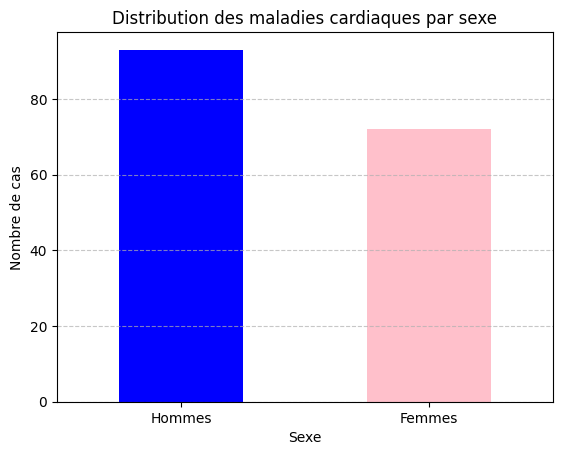

In [ ]:
import pandas as pd

# Charger le dataset
data = pd.read_csv("heart.csv")

# Vérifier la distribution des sexes avec une maladie cardiaque
sex_disease_distribution = data[data["target"] == 1]["sex"].value_counts()

# Associer les sexes à des noms compréhensibles
sex_labels = {0: "Femmes", 1: "Hommes"}
sex_disease_distribution.index = sex_disease_distribution.index.map(sex_labels)

# Afficher les résultats
print("Répartition des maladies cardiaques par sexe :")
print(sex_disease_distribution)

# Visualisation des données
import matplotlib.pyplot as plt

sex_disease_distribution.plot(kind="bar", color=["blue", "pink"])
plt.title("Distribution des maladies cardiaques par sexe")
plt.ylabel("Nombre de cas")
plt.xlabel("Sexe")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# **Prédiction de maladie cardiaque en fonction d'age**

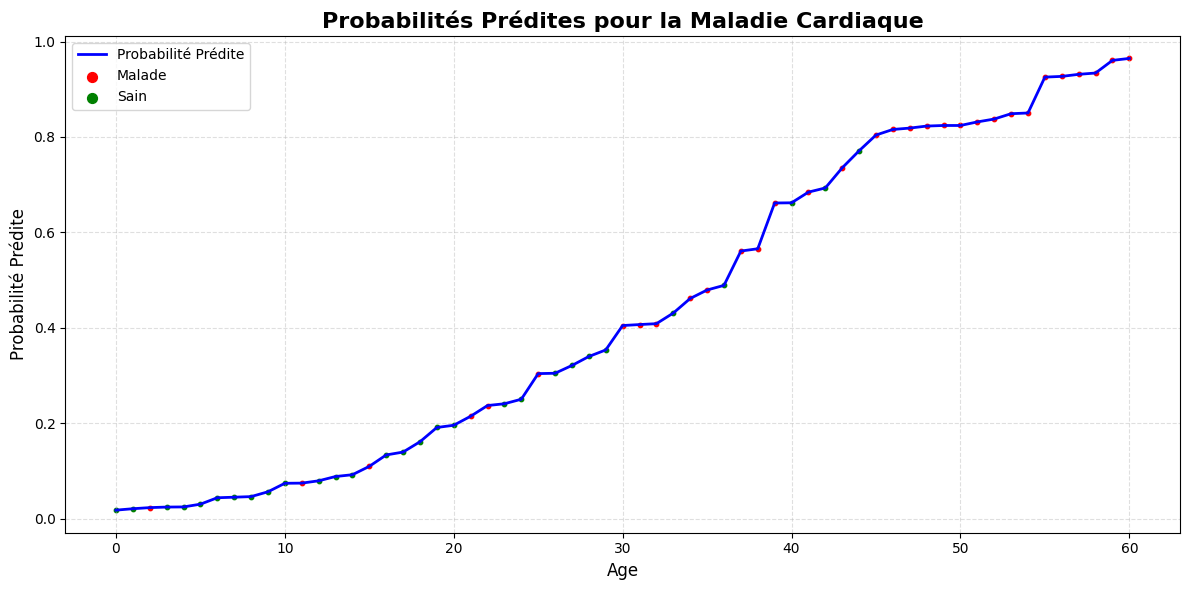

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Charger le dataset
data = pd.read_csv("heart.csv")

# Nettoyage des données : traitement des valeurs manquantes
columns_with_missing_data = ['chol', 'trestbps', 'thalach']
for column in columns_with_missing_data:
    if column in data.columns:
        data[column].fillna(data[column].mean(), inplace=True)

# Sélectionner les colonnes nécessaires
columns_needed = ["age", "sex", "chol", "trestbps", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"]
existing_columns = [col for col in columns_needed if col in data.columns]

# Préparer les données X (caractéristiques) et y (cible)
X = data[existing_columns]
y = data["target"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normaliser les caractéristiques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entraîner un modèle de régression logistique
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Prédire les probabilités pour la classe positive
probabilities = model.predict_proba(X_test_scaled)[:, 1]

# Organiser les résultats pour un tracé plus clair
results = pd.DataFrame({'Probabilité': probabilities, 'Vraie Classe': y_test}).sort_values(by='Probabilité')

# Tracer la courbe des probabilités
plt.figure(figsize=(12, 6))
plt.plot(results['Probabilité'].values, label='Probabilité Prédite', color='blue', linewidth=2)

# Ajouter des annotations pour les vraies classes dans le graphique
for idx, true_class in enumerate(results['Vraie Classe'].values):
    color = 'red' if true_class == 1 else 'green'
    plt.scatter(idx, results['Probabilité'].iloc[idx], color=color, s=10)

# Ajouter manuellement des points pour la légende
plt.scatter([], [], color='red', label='Malade', s=50)  # Point rouge pour "Malade"
plt.scatter([], [], color='green', label='Sain', s=50)  # Point vert pour "Sain"

# Ajouter les labels et le titre
plt.title("Probabilités Prédites pour la Maladie Cardiaque", fontsize=16, fontweight='bold')
plt.xlabel("Age", fontsize=12)
plt.ylabel("Probabilité Prédite", fontsize=12)

# Ajouter une légende
plt.legend(fontsize=10)
plt.grid(alpha=0.4, linestyle='--')

# Améliorer l'espacement et afficher la courbe
plt.tight_layout()
plt.show()

